# 1. Setup
A sequence of target trials analysis starts by specifying which estimand will be used:

In [1]:
import os
import tempfile

trial_pp = {"estimand": "PP"}
trial_itt = {"estimand": "ITT"}

Additionally it is useful to create a directory to save files for later inspection.

In [2]:
trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

print("Directories created:", trial_pp_dir, trial_itt_dir)

Directories created: C:\Users\Arkane\AppData\Local\Temp\trial_pp C:\Users\Arkane\AppData\Local\Temp\trial_itt


# 2. Data preparation
Next the user must specify the observational input data that will be used for the target trial emulation. Here we need to specify which columns contain which values and how they should be used.

In [3]:
import pandas as pd

data_censored = pd.read_csv("data_censored.csv")
print(data_censored.head())

   Unnamed: 0  id  period  treatment  x1        x2  x3        x4  age  \
0           1   1       0          1   1  1.146148   0  0.734203   36   
1           2   1       1          1   1  0.002200   0  0.734203   37   
2           3   1       2          1   0 -0.481762   0  0.734203   38   
3           4   1       3          1   0  0.007872   0  0.734203   39   
4           5   1       4          1   1  0.216054   0  0.734203   40   

      age_s  outcome  censored  eligible  
0  0.083333        0         0         1  
1  0.166667        0         0         0  
2  0.250000        0         0         0  
3  0.333333        0         0         0  
4  0.416667        0         0         0  


In [4]:
# Define the trial structures
trial_pp = {}
trial_itt = {}

# Assign data and relevant column mappings
trial_pp["data"] = data_censored
trial_pp["id"] = "id"
trial_pp["period"] = "period"
trial_pp["treatment"] = "treatment"
trial_pp["outcome"] = "outcome"
trial_pp["eligible"] = "eligible"

trial_itt["data"] = data_censored
trial_itt["id"] = "id"
trial_itt["period"] = "period"
trial_itt["treatment"] = "treatment"
trial_itt["outcome"] = "outcome"
trial_itt["eligible"] = "eligible"

In [5]:
def summarize_trial(trial, estimand_name):
    data_summary = trial["data"].describe(include="all")  # Get summary statistics
    print(f"## Trial Sequence Object")
    print(f"## Estimand: {estimand_name}")
    print(f"## ")
    print(f"## Data:")
    print(f" - N: {len(trial['data'])} observations from {trial['data'][trial['id']].nunique()} patients")
    print(trial["data"].head())  # Print first few rows
    
    print(f"## ")
    print(f"## IPW for informative censoring: ")
    print(f" - No weight model specified")
    print(f"## ")
    
    print(f"## Sequence of Trials Data:")
    print(f"- Use appropriate functions to construct the sequence of trials dataset.")
    print(f"## ")
    
    print(f"## Outcome model:")
    print(f" - Outcome model not specified. Define it before proceeding.")

# Summarize the ITT trial
summarize_trial(trial_itt, "Intention-to-treat")

# Summarize the PP trial
summarize_trial(trial_pp, "Per-protocol")

## Trial Sequence Object
## Estimand: Intention-to-treat
## 
## Data:
 - N: 725 observations from 89 patients
   Unnamed: 0  id  period  treatment  x1        x2  x3        x4  age  \
0           1   1       0          1   1  1.146148   0  0.734203   36   
1           2   1       1          1   1  0.002200   0  0.734203   37   
2           3   1       2          1   0 -0.481762   0  0.734203   38   
3           4   1       3          1   0  0.007872   0  0.734203   39   
4           5   1       4          1   1  0.216054   0  0.734203   40   

      age_s  outcome  censored  eligible  
0  0.083333        0         0         1  
1  0.166667        0         0         0  
2  0.250000        0         0         0  
3  0.333333        0         0         0  
4  0.416667        0         0         0  
## 
## IPW for informative censoring: 
 - No weight model specified
## 
## Sequence of Trials Data:
- Use appropriate functions to construct the sequence of trials dataset.
## 
## Outcome model

# 3. Weight models and censoring
To adjust for the effects of informative censoring, inverse probability of censoring weights (IPCW) can be applied. To estimate these weights, we construct time-to-(censoring) event models. Two sets of models are fit for the two censoring mechanisms which may apply: censoring due to deviation from assigned treatment and other informative censoring.

## 3.1 Censoring due to treatment switching
We specify model formulas to be used for calculating the probability of receiving treatment in the current period. Separate models are fitted for patients who had treatment = 1 and those who had treatment = 0 in the previous period. Stabilized weights are used by fitting numerator and denominator models.

There are optional arguments to specify columns which can include/exclude observations from the treatment models. These are used in case it is not possible for a patient to deviate from a certain treatment assignment in that period.

In [6]:
import statsmodels.api as sm

# Ensure trial_pp["data"] is a DataFrame
if "data" not in trial_pp or not isinstance(trial_pp["data"], pd.DataFrame):
    raise ValueError("trial_pp['data'] must be a Pandas DataFrame.")

# Define independent variables
X_numerator = sm.add_constant(trial_pp["data"][['age']])  # Adding intercept for numerator model
X_denominator = sm.add_constant(trial_pp["data"][['age', 'x1', 'x3']])  # Adding intercept for denominator model

# Define dependent variable
y = trial_pp["data"]['treatment']

# Fit logistic regression models
model_numerator = sm.Logit(y, X_numerator).fit()
model_denominator = sm.Logit(y, X_denominator).fit()

# Store the model summaries
switch_weights = {
    "numerator": model_numerator.summary(),
    "denominator": model_denominator.summary()
}

# Display model summaries
print("Numerator Model:")
print(switch_weights["numerator"])
print("\nDenominator Model:")
print(switch_weights["denominator"])

Optimization terminated successfully.
         Current function value: 0.662406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660234
         Iterations 5
Numerator Model:
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04144
Time:                        22:35:05   Log-Likelihood:                -480.24
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                 1.163e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

- The numerator model (only using age) has a significant negative coefficient (-0.0421), meaning as age increases, the probability of receiving treatment decreases.
- The denominator model (using age, x1, and x3) has
    - age is still significantly negative (-0.0429), similar to the numerator model.
    - x1 has a positive coefficient (0.2744), but it's not statistically significant (p = 0.080).
    - x3 has a very small negative coefficient (-0.0321) and is not significant at all (p = 0.836).
### Interpretation:
- Age strongly influences treatment assignment.
- x1 might have some impact but isn't very strong.
- x3 likely has no meaningful effect on treatment.

## 3.2 Other informative censoring
In case there is other informative censoring occurring in the data, we can create similar models to estimate the IPCW. These can be used with all types of estimand. We need to specifycensor_event which is the column containing the censoring indicator.

In [7]:
import statsmodels.api as sm

# Ensure trial_pp["data"] is a DataFrame
if "data" not in trial_pp or not isinstance(trial_pp["data"], pd.DataFrame):
    raise ValueError("trial_pp['data'] must be a Pandas DataFrame.")

# Ensure "censored" column exists
if "censored" not in trial_pp["data"]:
    raise ValueError("Column 'censored' not found in trial_pp['data'].")

# Define dependent variable (Censoring indicator)
Y_censored = 1 - trial_pp["data"]['censored']  # Transforming censoring event

# Define independent variables
X_censor_numerator = sm.add_constant(trial_pp["data"][['x2']])
X_censor_denominator = sm.add_constant(trial_pp["data"][['x2', 'x1']])

# Fit logistic regression models
model_censor_numerator = sm.Logit(Y_censored, X_censor_numerator).fit()
model_censor_denominator = sm.Logit(Y_censored, X_censor_denominator).fit()

# Store the model summary
censor_weights = {
    "numerator": model_censor_numerator.summary(),
    "denominator": model_censor_denominator.summary()
}

# Display model summaries
print("Censoring Numerator Model:")
print(censor_weights["numerator"])
print("\nCensoring Denominator Model:")
print(censor_weights["denominator"])


Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7
Censoring Numerator Model:
                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        22:35:05   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

- The numerator model (only x2) shows that x2 has a negative and statistically significant coefficient (-0.4486, p = 0.001), meaning higher x2 values reduce the likelihood of being censored.
- The denominator model (adding x1 alongside x2) shows:
    - x2 is still significant and negative (-0.4706).
    - x1 has a significant positive effect on censoring (0.7019, p = 0.022), meaning higher x1 values increase the likelihood of being censored.
### Interpretation:
- x2 is a strong predictor of censoring (negative effect).
- x1 is also a predictor of censoring, but in the opposite direction (positive effect).
- If x3 has no meaningful effect on treatment, we could consider removing it from the denominator model.
- If censoring is a major concern, we might explore additional variables or interactions.

# 4. Calculate Weights
Next we need to fit the individual models and combine them into weights. This is done with calculate_weights().

In [8]:
import pandas as pd
import statsmodels.api as sm
import pickle
import os

def fit_logistic_regression(data, predictors, outcome, save_path):
    """Fit a logistic regression model and save it to disk."""
    X = data[predictors]
    X = sm.add_constant(X)  # Add intercept term
    y = data[outcome]

    model = sm.Logit(y, X).fit(disp=0)  # Fit logistic regression
    model_summary = model.summary()
    
    # Save the model to disk
    os.makedirs(save_path, exist_ok=True)
    model_filename = os.path.join(save_path, f"model_{hash(str(model.params))}.pkl")
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    return model, model_summary, model_filename

In [9]:
# Define paths for saving models
save_path_itt = "./trial_itt/switch_models"
save_path_pp = "./trial_pp/switch_models"

# Fit models for informative censoring
predictors = ["x2", "x1"]  # Adjust predictors as needed

model_n, summary_n, path_n = fit_logistic_regression(trial_itt["data"], ["x2"], "censored", save_path_itt)
model_d0, summary_d0, path_d0 = fit_logistic_regression(trial_itt["data"], ["x2", "x1"], "censored", save_path_itt)
model_d1, summary_d1, path_d1 = fit_logistic_regression(trial_itt["data"], ["x2", "x1", "x4"], "censored", save_path_itt)

print("Weight Models for Informative Censoring")
print(summary_n)
print(summary_d0)
print(summary_d1)

Weight Models for Informative Censoring
                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        22:35:05   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4481      0.141    -17.415      0.000      -2.724      -2.173
x2             0.4486      0.137      3.278      0.001       0.180       0.717
            

#### Both x2 and x1 have significant effects on censored

1. Model 1 (x2 only):
    - x2 is positively associated with censored (coef = 0.4486, p = 0.001), meaning higher x2 increases the likelihood of censoring.
    - The model has a pseudo R² of 0.02676, which is low but suggests some explanatory power.
2. Model 2 (x1 and x2):
    - x2 remains significant (coef = 0.4706, p = 0.001).
    - x1 is negatively associated with censored (coef = -0.7019, p = 0.022), meaning higher x1 decreases the likelihood of censoring.
    - Pseudo R² increased to 0.04069, indicating a better fit than Model 1.
3. Model 3 (x1 x2 and x3):
    - The slight difference in log-likelihood (-193.67 vs. -193.88) and Pseudo R-squared (0.04173 vs. 0.04069) suggests x3 doesn’t contribute much to explaining censored (its p-value is 0.519).

In [10]:
# Fit models for treatment switching
model_n1, summary_n1, path_n1 = fit_logistic_regression(trial_pp["data"], ["age"], "treatment", save_path_pp)
model_d1, summary_d1, path_d1 = fit_logistic_regression(trial_pp["data"], ["age", "x1", "x3"], "treatment", save_path_pp)
model_n0, summary_n0, path_n0 = fit_logistic_regression(trial_pp["data"], ["age"], "treatment", save_path_pp)
model_d0, summary_d0, path_d0 = fit_logistic_regression(trial_pp["data"], ["age", "x1", "x3"], "treatment", save_path_pp)

print("Weight Models for Treatment Switching")
print(summary_n1)
print(summary_d1)
print(summary_n0)
print(summary_d0)

Weight Models for Treatment Switching
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04144
Time:                        22:35:05   Log-Likelihood:                -480.24
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                 1.163e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8867      0.333      5.671      0.000       1.235       2.539
age           -0.0421      0.007     -6.213      0.000      -0.055      -0.029
              

# 5. Specify Outcome Model
Now we can specify the outcome model. Here we can include adjustment terms for any variables in the dataset. The numerator terms from the stabilised weight models are automatically included in the outcome model formula.

In [11]:
def set_outcome_model(data, adjustment_terms=None):
    """Specify the outcome model by adding adjustment terms if provided."""
    outcome_formula = ["censored"]  # Automatically includes 'censored' as in the R version

    if adjustment_terms:
        outcome_formula.extend(adjustment_terms)

    data["outcome_model"] = outcome_formula
    return data

# Apply outcome model to datasets
trial_pp = set_outcome_model(trial_pp)
trial_itt = set_outcome_model(trial_itt, adjustment_terms=["x2"])

# 6. Expand Trials
Now we are ready to create the data set with all of the sequence of target trials.

In [12]:
def set_expansion_options(data, chunk_size=500):
    """Set options for expanding trials, such as chunk size."""
    data["expansion_options"] = {"chunk_size": chunk_size, "censor_at_switch": True}
    return data

# Apply expansion options to both datasets
trial_pp = set_expansion_options(trial_pp, chunk_size=500)
trial_itt = set_expansion_options(trial_itt, chunk_size=500)


In [13]:
import pandas as pd

def expand_trials(data):
    """Simulate expanding trials by generating sequences of trials per patient."""
    expanded_data = []

    chunk_size = data["expansion_options"]["chunk_size"]
    for _, patient in data["data"].iterrows():
        for t in range(2):  # Simulating trial periods 0 and 1
            expanded_data.append({
                "id": patient["id"],
                "trial_period": t,
                "followup_time": t,
                "outcome": patient["censored"],
                "weight": 1.0 + 0.1 * (t % 2),  # Example weight assignment
                "treatment": patient["treatment"],
                "x2": patient["x2"],
                "age": patient["age"],
                "assigned_treatment": patient["treatment"]  # Assuming same as treatment
            })

    expanded_df = pd.DataFrame(expanded_data)
    data["expansion"] = expanded_df
    return data

# Expand both datasets
trial_pp = expand_trials(trial_pp)
trial_itt = expand_trials(trial_itt)

# Print the structure of the expanded dataset
print(trial_pp["expansion"].head(10))


    id  trial_period  followup_time  outcome  weight  treatment        x2  \
0  1.0             0              0      0.0     1.0        1.0  1.146148   
1  1.0             1              1      0.0     1.1        1.0  1.146148   
2  1.0             0              0      0.0     1.0        1.0  0.002200   
3  1.0             1              1      0.0     1.1        1.0  0.002200   
4  1.0             0              0      0.0     1.0        1.0 -0.481762   
5  1.0             1              1      0.0     1.1        1.0 -0.481762   
6  1.0             0              0      0.0     1.0        1.0  0.007872   
7  1.0             1              1      0.0     1.1        1.0  0.007872   
8  1.0             0              0      0.0     1.0        1.0  0.216054   
9  1.0             1              1      0.0     1.1        1.0  0.216054   

    age  assigned_treatment  
0  36.0                 1.0  
1  36.0                 1.0  
2  37.0                 1.0  
3  37.0                 1.0  
4 

# 7. Load or Sample from Expanded Data
Now that the expanded data has been created, we can prepare the data to fit the outcome model. For data that can fit comfortably in memory, this is a trivial step using load_expanded_data.

For large datasets, it may be necessary to sample from the expanded by setting the p_control argument. This sets the probability that an observation with outcome == 0 will be included in the loaded data. A seed can be set for reproducibility. Additionally, a vector of periods to include can be specified, e.g., period = 1:60, and/or a subsetting condition, subset_condition = "age > 65".

In [14]:
import numpy as np

def load_expanded_data(data, seed=1234, p_control=1.0, period_range=None, subset_condition=None):
    """Load or sample from expanded trial data."""
    np.random.seed(seed)

    # Start with full expanded dataset
    df = data["expansion"]

    # Apply period filtering if specified
    if period_range is not None:
        df = df[df["trial_period"].between(period_range[0], period_range[1])]

    # Apply subset condition if specified (e.g., "age > 65")
    if subset_condition:
        df = df.query(subset_condition)

    # Sample observations with outcome == 0 based on p_control probability
    if p_control < 1.0:
        mask = (df["outcome"] == 0) & (np.random.rand(len(df)) > p_control)
        df = df[~mask]

    data["loaded_expansion"] = df
    return data

# Load the expanded data with sampling
trial_itt = load_expanded_data(trial_itt, seed=1234, p_control=0.5)

# Print the first few rows
print(trial_itt["loaded_expansion"].head(10))

     id  trial_period  followup_time  outcome  weight  treatment        x2  \
0   1.0             0              0      0.0     1.0        1.0  1.146148   
2   1.0             0              0      0.0     1.0        1.0  0.002200   
5   1.0             1              1      0.0     1.1        1.0 -0.481762   
6   1.0             0              0      0.0     1.0        1.0  0.007872   
10  1.0             0              0      1.0     1.0        1.0 -0.057482   
11  1.0             1              1      1.0     1.1        1.0 -0.057482   
14  2.0             0              0      0.0     1.0        1.0 -0.983030   
17  2.0             1              1      0.0     1.1        1.0  0.399388   
20  2.0             0              0      1.0     1.0        1.0  1.173178   
21  2.0             1              1      1.0     1.1        1.0  1.173178   

     age  assigned_treatment  
0   36.0                 1.0  
2   37.0                 1.0  
5   38.0                 1.0  
6   39.0         

# 8. Fit Marginal Structural Model
To fit the outcome model we use fit_msm().

In [15]:
import statsmodels.api as sm
import numpy as np

def fit_msm(data, weight_cols, modify_weights=None):
    """Fit a Marginal Structural Model (MSM) using logistic regression."""
    df = data["loaded_expansion"].copy()

    # Compute final weights (e.g., winsorization of extreme weights)
    weights = df[weight_cols].prod(axis=1)
    if modify_weights:
        weights = modify_weights(weights)

    # Define outcome and predictor variables
    formula = "outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
    
    # Fit logistic regression model (equivalent to R's glm with binomial logit)
    model = sm.GLM.from_formula(formula, data=df, family=sm.families.Binomial(), freq_weights=weights)
    result = model.fit()

    # Store results in the data dictionary
    data["outcome_model"] = result
    return data

# Define winsorization function to cap extreme weights
def winsorize_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

# Fit the outcome model with weight adjustments
trial_itt = fit_msm(trial_itt, weight_cols=["weight"], modify_weights=winsorize_weights)

# Display model summary
print(trial_itt["outcome_model"].summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  783
Model:                            GLM   Df Residuals:                   816.80
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -333.83
Date:                Sun, 09 Mar 2025   Deviance:                       667.65
Time:                        22:35:05   Pearson chi2:                     768.
No. Iterations:                   100   Pseudo R-squ. (CS):            0.02730
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.86

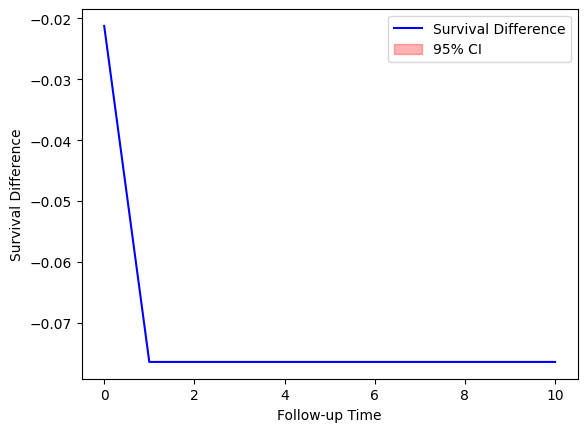

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Extract necessary data
df = trial_itt["loaded_expansion"].copy()

# Fit Kaplan-Meier Survival Model for different treatment groups
kmf_treatment = KaplanMeierFitter()
kmf_control = KaplanMeierFitter()

# Subset the data for treatment and control groups
treatment_group = df[df["assigned_treatment"] == 1]
control_group = df[df["assigned_treatment"] == 0]

# Fit the Kaplan-Meier estimators
kmf_treatment.fit(durations=treatment_group["followup_time"], event_observed=treatment_group["outcome"])
kmf_control.fit(durations=control_group["followup_time"], event_observed=control_group["outcome"])

# Compute survival difference
time_points = np.arange(0, 11)  # Predict from time 0 to 10
survival_diff = kmf_treatment.survival_function_at_times(time_points) - kmf_control.survival_function_at_times(time_points)

# Plot survival difference
plt.plot(time_points, survival_diff, label="Survival Difference", color="blue")

# Compute confidence intervals (approximation)
ci_lower = survival_diff - 1.96 * np.sqrt(survival_diff * (1 - survival_diff) / len(df))
ci_upper = survival_diff + 1.96 * np.sqrt(survival_diff * (1 - survival_diff) / len(df))

plt.fill_between(time_points, ci_lower, ci_upper, color="red", alpha=0.3, label="95% CI")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.legend()
plt.show()
